In [1]:
!bash ./data/refresh_data.sh

--2020-07-15 20:56:49--  https://www.vdh.virginia.gov/content/uploads/sites/182/2020/05/VDH-COVID-19-PublicUseDataset-Cases.csv
Resolving www.vdh.virginia.gov (www.vdh.virginia.gov)... 166.67.72.247
Connecting to www.vdh.virginia.gov (www.vdh.virginia.gov)|166.67.72.247|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 762434 (745K) [application/octet-stream]
Saving to: ‘VDH-COVID-19-PublicUseDataset-Cases.csv’

VDH-COVID-19-Public 100%[===================>] 744.56K  --.-KB/s    in 0.1s    

2020-07-15 20:56:49 (5.93 MB/s) - ‘VDH-COVID-19-PublicUseDataset-Cases.csv’ saved [762434/762434]

--2020-07-15 20:56:49--  https://www.vdh.virginia.gov/content/uploads/sites/182/2020/05/VDH-COVID-19-PublicUseDataset-Tests_by-LabReportDate.csv
Resolving www.vdh.virginia.gov (www.vdh.virginia.gov)... 166.67.72.247
Connecting to www.vdh.virginia.gov (www.vdh.virginia.gov)|166.67.72.247|:443... connected.
  Unable to locally ve

In [2]:
import urllib
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

CASES_DATASET = "VDH-COVID-19-PublicUseDataset-Cases.csv"
TESTING_DATASET = "VDH-COVID-19-PublicUseDataset-Tests_by-LabReportDate.csv"

COUNTIES = frozenset({"Alexandria", "Arlington","Fairfax"})

cases = pd.read_csv(os.path.join("./data", CASES_DATASET))
cases["Datetime"] = pd.to_datetime(cases["Report Date"])
tests = pd.read_csv(os.path.join("./data",TESTING_DATASET))

cases.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,Datetime
0,7/15/2020,51001,Accomack,Eastern Shore,1045,72,14,2020-07-15
1,7/15/2020,51003,Albemarle,Thomas Jefferson,583,39,10,2020-07-15
2,7/15/2020,51005,Alleghany,Alleghany,53,5,2,2020-07-15
3,7/15/2020,51007,Amelia,Piedmont,55,12,1,2020-07-15
4,7/15/2020,51009,Amherst,Central Virginia,42,3,0,2020-07-15


In [3]:
def get_daily_cases_moving_avg(data, counties, avg=7):
    total_cases = pd.DataFrame(
        data[data["Locality"].isin(counties)].groupby("Report Date")["Total Cases"].agg("sum")
    )
    total_cases.reset_index(inplace=True)
    total_cases["Datetime"] = pd.to_datetime(total_cases["Report Date"])
    total_cases.sort_values(by="Datetime", inplace=True)

    total_cases["Daily"] = total_cases["Total Cases"].diff()
    total_cases[f"{avg} day avg"] = total_cases["Daily"].rolling(avg).mean()

    total_cases["pct change"] = total_cases[f"{avg} day avg"].pct_change()
    
    return total_cases

def get_daily_testing_moving_avg(data, counties, avg=7):
    TOTAL_POS_TESTS_COL = "Total Number of Positive Testing Encounters"
    TOTAL_PCR_TESTS_COL = "Number of PCR Testing Encounters"
    TOTAL_TESTS_COL = "Total Number of Testing Encounters"
    TOTAL_POS_PCR_TESTS_COL = "Number of Positive PCR Testing Encounters"
    
    tests = data[
        (data["Health District"].isin(counties)) & (data["Lab Report Date"] !="Not Reported")
    ]
    tests["Datetime"] = pd.to_datetime(tests["Lab Report Date"])
    
    total_tests = pd.DataFrame(
        tests.groupby("Datetime")[TOTAL_TESTS_COL].agg("sum")
    )
    
    total_tests["positive tests"] = tests.groupby("Datetime")[TOTAL_POS_TESTS_COL].agg("sum")
    total_tests["Total PCR"] = tests.groupby("Datetime")[TOTAL_PCR_TESTS_COL].agg("sum")
    total_tests["pcr positive tests"] = tests.groupby("Datetime")[TOTAL_POS_PCR_TESTS_COL].agg("sum")

    total_tests["pct positive"] = total_tests["positive tests"]/total_tests["Total Number of Testing Encounters"]
    total_tests["pct pcr positive"] = total_tests["pcr positive tests"]/total_tests["Total PCR"]

    total_tests[f"pct positive {avg} day avg"] = total_tests["pct positive"].rolling(avg).mean()
    total_tests[f"pct pcr positive {avg} day avg"] = total_tests["pct pcr positive"].rolling(avg).mean()
    total_tests.reset_index(inplace=True)
    return total_tests

    
def plot_case_counts(dataframes):
    sns.set(style="white", palette="muted", color_codes=True)
    f, axes = plt.subplots(1, 2, figsize=(20,10))
    
    for label, data in dataframes.items():
        pct_change = data["pct change"].to_list()[-1]
        left = sns.lineplot(x="Datetime", y="Total Cases", data=data, ax=axes[0],label=label)
        right = sns.lineplot(
            x="Datetime", y="7 day avg", data=data, ax=axes[1], label=f"{label} {pct_change*100:.2f}%")

    left.set_title("Cummulative Casses")
    right.set_title("7 day moving average")    
    title = (f"Total Cases as of {data.iloc[-1]['Report Date']}\n"
             f"for {', '.join([county for county in dataframes.keys() if county!='Total cases'])}"
            )
    a = f.suptitle(title, fontsize=20)
    plt.show()
    

def plot_pos_testing_rates(dataframes):
    sns.set(style="white", palette="muted", color_codes=True)
    f, axes = plt.subplots(1, 2, figsize=(20,10))
    
    for label, data in dataframes.items():
        left = sns.lineplot(x="Datetime", y="pct positive 7 day avg", data=data, ax=axes[0], label=label)
        right = sns.lineplot(x="Datetime", y="pct pcr positive 7 day avg", data=data, ax=axes[1], label=label)
        
    left.set_title("7 day moving avg: Total Tests")
    right.set_title("7 day moving avg: PCR Tests")
    
    left.axhline(0.05, color="r", ls="--")
    right.axhline(0.05, color="r", ls="--")
    title = "Percentage of Positive Tests"
    a = f.suptitle(title, fontsize=20)
    plt.show()
    

In [4]:
cases = {
    "Alexandria": get_daily_cases_moving_avg(cases, {"Alexandria"}, avg=7),
    "Fairfax": get_daily_cases_moving_avg(cases, {"Fairfax"}, avg=7),
    "Arlington": get_daily_cases_moving_avg(cases, {"Arlington"}, avg=7),
    "Total cases": get_daily_cases_moving_avg(cases, COUNTIES, avg=7)
}

tests = {
    "Alexandria": get_daily_testing_moving_avg(tests, {"Alexandria"}, avg=7),
    "Fairfax": get_daily_testing_moving_avg(tests, {"Fairfax"}, avg=7),
    "Arlington": get_daily_testing_moving_avg(tests, {"Arlington"}, avg=7),
    "Total cases": get_daily_testing_moving_avg(tests, COUNTIES, avg=7)
}

<ipython-input-3-741b80d5eec5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tests["Datetime"] = pd.to_datetime(tests["Lab Report Date"])


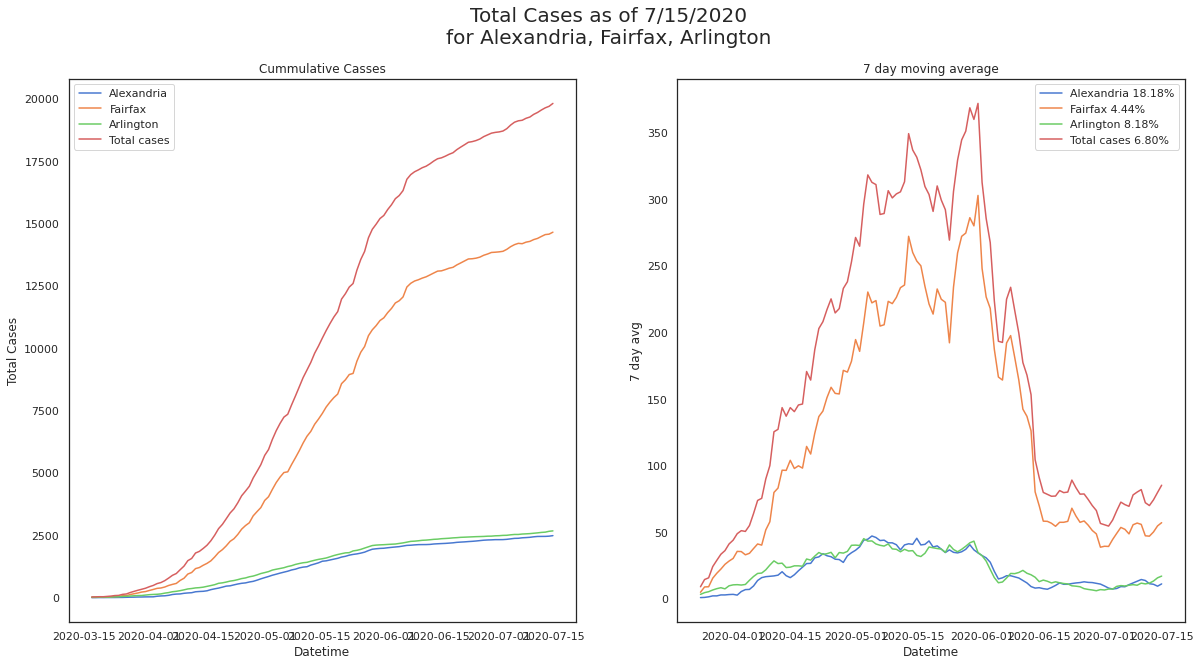

In [5]:
plot_case_counts(cases)

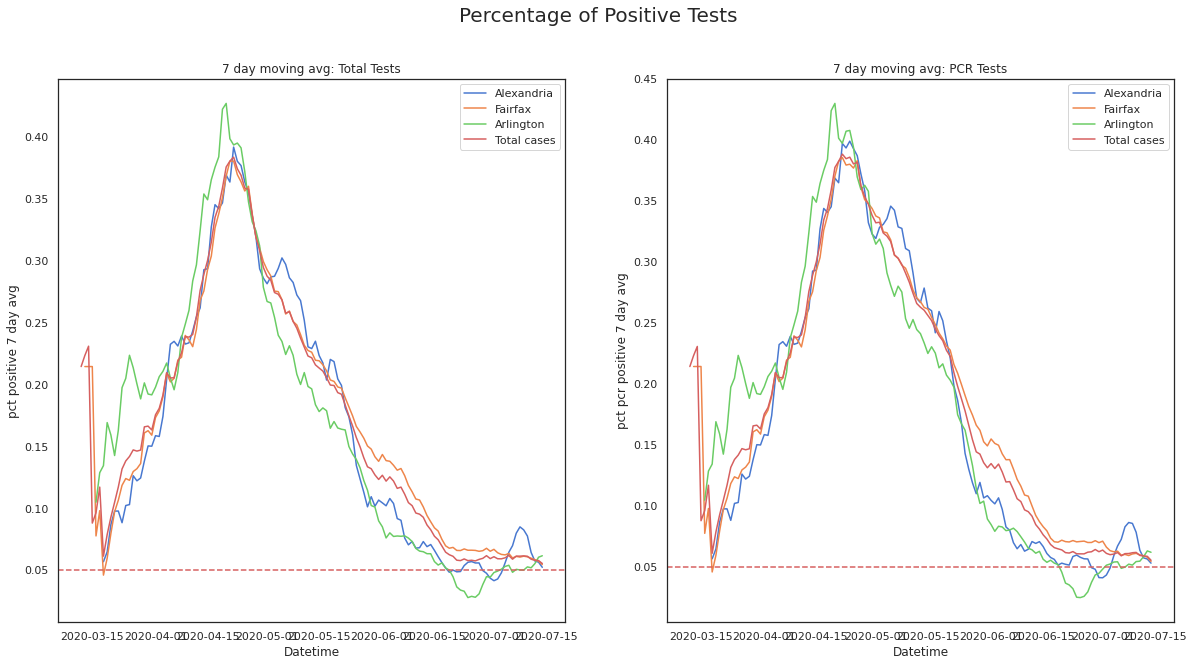

In [6]:
plot_pos_testing_rates(tests)